In [14]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift

import time

In [15]:
num_features=20
num_samples=200000
    
mue = np.random.uniform(-2, 2, (num_features, 1))        
sigma = np.random.uniform(0.9, 1.1, (num_features, 1))

X = np.random.normal(mue, sigma, size=(num_features, num_samples)).T

In [16]:
epsilon = np.random.normal(0, 1, num_samples)

beta = np.random.uniform(-5, 5, num_features + 1)
beta[1:] = [1] * num_features

Y = beta[0] + np.sum(np.multiply(beta[1:], X), axis=1) + epsilon

In [17]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    
    def forward(self, input):
        return self.net(input)

class Net_dropout(nn.Module):

    def __init__(self):
        super(Net_dropout, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    
    def forward(self, input):
        return self.net(input)

In [18]:
test_samples = 200 * 600

X_train = X[test_samples:]
Y_train = Y[test_samples:]

X_test = X[:test_samples]
Y_test = Y[:test_samples]

In [19]:
def train_net(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

    score = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

    print(score)

In [20]:
def time_attribute_tabular_features(net, algorithm, input, name, baseline=0, samples=50):
    net.zero_grad()

    start = time.perf_counter()

    if name == "DeepLift":

        tensor_attributions = algorithm.attribute(input, baselines=baseline)

    elif name == "Integrated Gradients":

         tensor_attributions = algorithm.attribute(input, baselines=baseline, n_steps=samples)

    elif name in ["SmoothGrad", "SmoothGradxInput"]:

        tensor_attributions = algorithm.attribute(input, nt_samples=samples)

    else:

        tensor_attributions = algorithm.attribute(input)
    
    end = time.perf_counter()

    elapsed_ms = (end - start) * 1000
    
    return elapsed_ms

In [21]:
data = []

net = Net()

train_net(net)

net.eval()

sal = Saliency(net)

ig = IntegratedGradients(net)

dl = DeepLift(net)

smg = NoiseTunnel(sal)

ixg = InputXGradient(net)

smgxi = NoiseTunnel(ixg)

lrp = LRP(net)

for num_test in range(10, 201, 10):

    ind = 0

    for i in range(500):

        X = torch.from_numpy(X_test[ind:ind+num_test]).type(torch.FloatTensor)

        ind += num_test

        for (algorithm, name) in zip((sal, smg, ixg, lrp, smgxi, ig, dl), 
                                 ("Grad/Saliency", "SmoothGrad", "GradientxInput", "LRP", "SmoothGradxInput",
                                   "Integrated Gradients", "DeepLift")):

            elapsed_time = time_attribute_tabular_features(net, algorithm, X, name)

            data.append({
                        'Test Samples': num_test,
                        'Method': name,
                        'Time': elapsed_time
                        })


tensor(0.9496)


/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/li

       Test Samples                Method        Time
0                10         Grad/Saliency    0.561166
1                10            SmoothGrad    3.006625
2                10        GradientxInput    0.268125
3                10                   LRP    0.903250
4                10      SmoothGradxInput    2.971416
...             ...                   ...         ...
69995           200        GradientxInput    1.864042
69996           200                   LRP    2.892625
69997           200      SmoothGradxInput  200.554375
69998           200  Integrated Gradients  199.673584
69999           200              DeepLift   29.666625

[70000 rows x 3 columns]


Text(0.5, 0, 'Time (ms)')

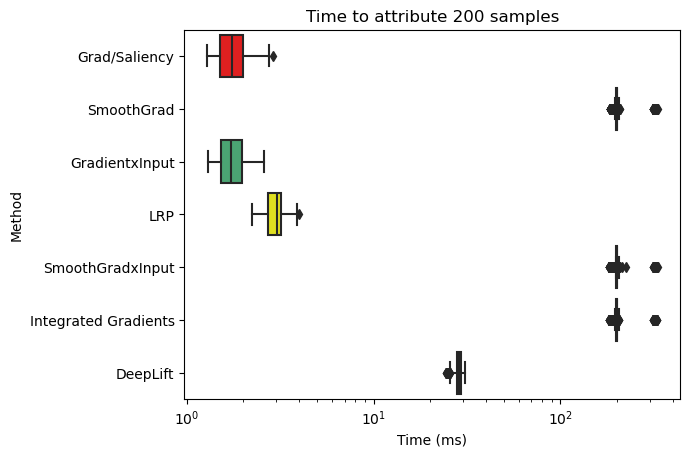

In [22]:
df = pd.DataFrame(data)
print(df)

method_colors = {
    "Grad/Saliency": 'red',
    "SmoothGrad": 'deepskyblue',
    "GradientxInput": 'mediumseagreen',
    "LRP": 'yellow',
    "SmoothGradxInput": 'navy',
    "Integrated Gradients": 'coral',
    "DeepLift": 'slateblue'
}

plot = sns.boxplot(x='Time', y='Method', data=df[df["Test Samples"] == 200], palette=method_colors)
plot.set_xscale("log")
plt.title("Time to attribute 200 samples")
plt.xlabel("Time (ms)")

     Test Samples                Method        Time
0              10              DeepLift    1.031880
1              10         Grad/Saliency    0.216751
2              10        GradientxInput    0.211731
3              10  Integrated Gradients    4.516465
4              10                   LRP    0.718559
..            ...                   ...         ...
135           200        GradientxInput    1.766311
136           200  Integrated Gradients  208.361604
137           200                   LRP    3.018954
138           200            SmoothGrad  209.907443
139           200      SmoothGradxInput  207.282358

[140 rows x 3 columns]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


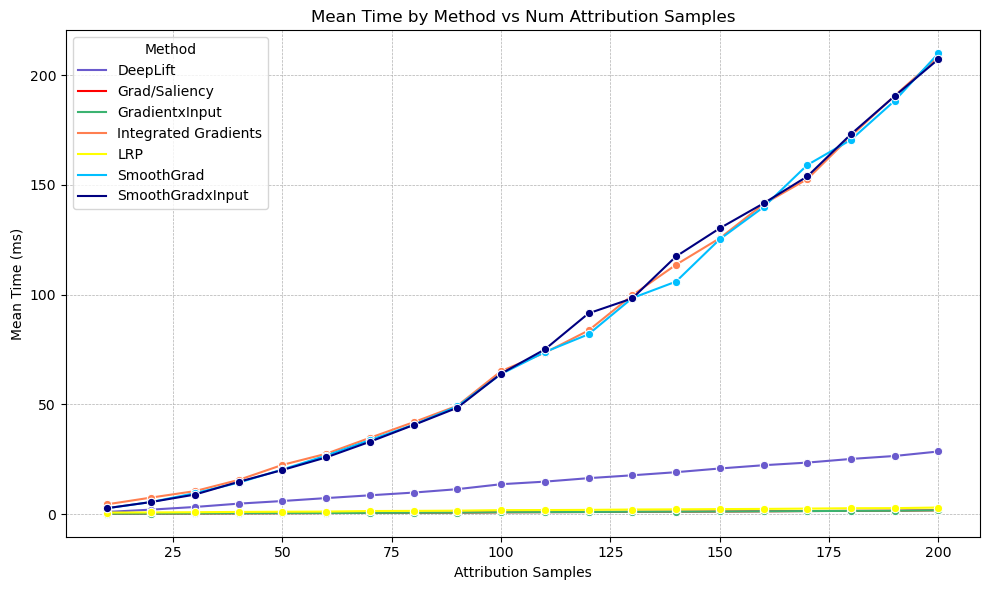

In [23]:

df_mean = df.groupby(['Test Samples', 'Method'])['Time'].mean().reset_index()
print(df_mean)


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_mean, x='Test Samples', y='Time', hue='Method', marker='o', palette=method_colors)


#plt.yscale('log')
#plt.xscale('log')

plt.title('Mean Time by Method vs Num Attribution Samples')
plt.xlabel('Attribution Samples')
plt.ylabel('Mean Time (ms)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Method')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


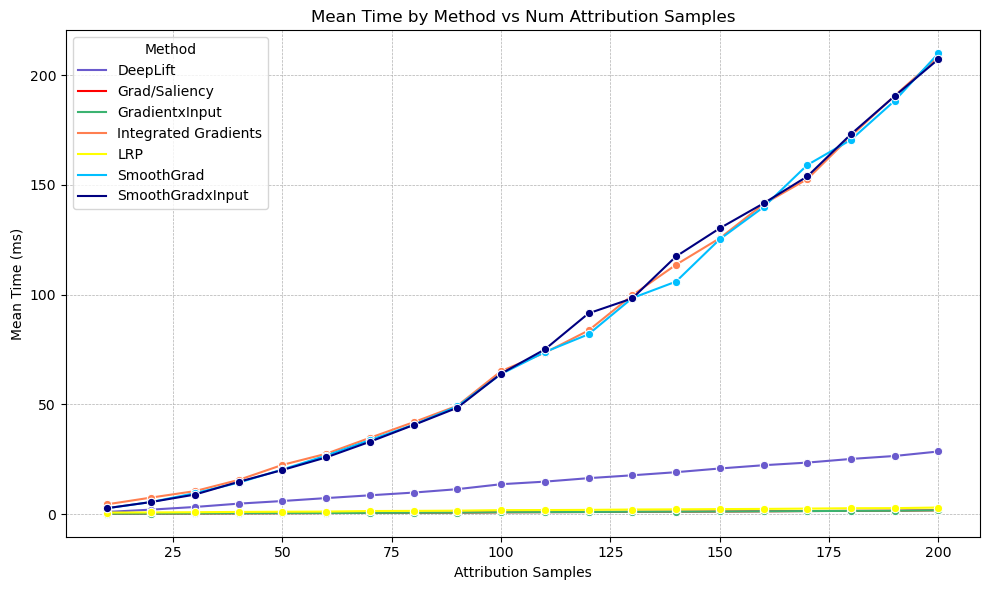

In [29]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_mean, x='Test Samples', y='Time', hue='Method', marker='o', palette=method_colors)


#plt.yscale('log')
#plt.xscale('log')

plt.title('Mean Time by Method vs Num Attribution Samples')
plt.xlabel('Attribution Samples')
plt.ylabel('Mean Time (ms)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Method')
plt.tight_layout()
plt.show()

       Test Samples                Method        Time
1                10            SmoothGrad    3.006625
4                10      SmoothGradxInput    2.971416
5                10  Integrated Gradients    4.487625
8                10            SmoothGrad    2.986666
11               10      SmoothGradxInput    2.811750
...             ...                   ...         ...
69990           200      SmoothGradxInput  199.647458
69991           200  Integrated Gradients  199.293000
69994           200            SmoothGrad  202.161250
69997           200      SmoothGradxInput  200.554375
69998           200  Integrated Gradients  199.673584

[30000 rows x 3 columns]


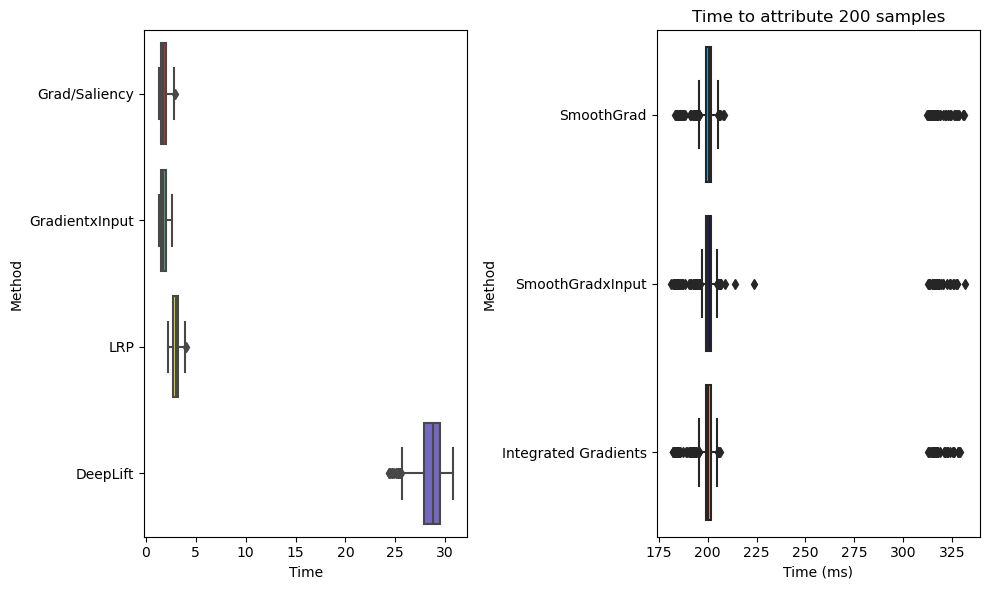

In [24]:
df1 = df[df["Method"].isin(["Grad/Saliency", "GradientxInput", "LRP", "DeepLift"])]
df2 = df[df["Method"].isin(["SmoothGrad", "SmoothGradxInput", "Integrated Gradients"])]
print(df2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(x='Time', y='Method', data=df1[df1["Test Samples"] == 200], ax=ax1, palette=method_colors)

plt.title("Time to attribute 200 samples")
plt.xlabel("Time (ms)")

sns.boxplot(x='Time', y='Method', data=df2[df2["Test Samples"] == 200], ax=ax2, palette=method_colors)

plt.xlabel("Time (ms)")

plt.tight_layout()
plt.show()

    Test Samples          Method       Time
0             10        DeepLift   1.031880
1             10   Grad/Saliency   0.216751
2             10  GradientxInput   0.211731
3             10             LRP   0.718559
4             20        DeepLift   2.069550
..           ...             ...        ...
75           190             LRP   2.748016
76           200        DeepLift  28.553729
77           200   Grad/Saliency   1.773164
78           200  GradientxInput   1.766311
79           200             LRP   3.018954

[80 rows x 3 columns]
    Test Samples                Method        Time
0             10  Integrated Gradients    4.516465
1             10            SmoothGrad    2.734608
2             10      SmoothGradxInput    2.753320
3             20  Integrated Gradients    7.561814
4             20            SmoothGrad    5.533494
5             20      SmoothGradxInput    5.530827
6             30  Integrated Gradients   10.503323
7             30            SmoothGrad   

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

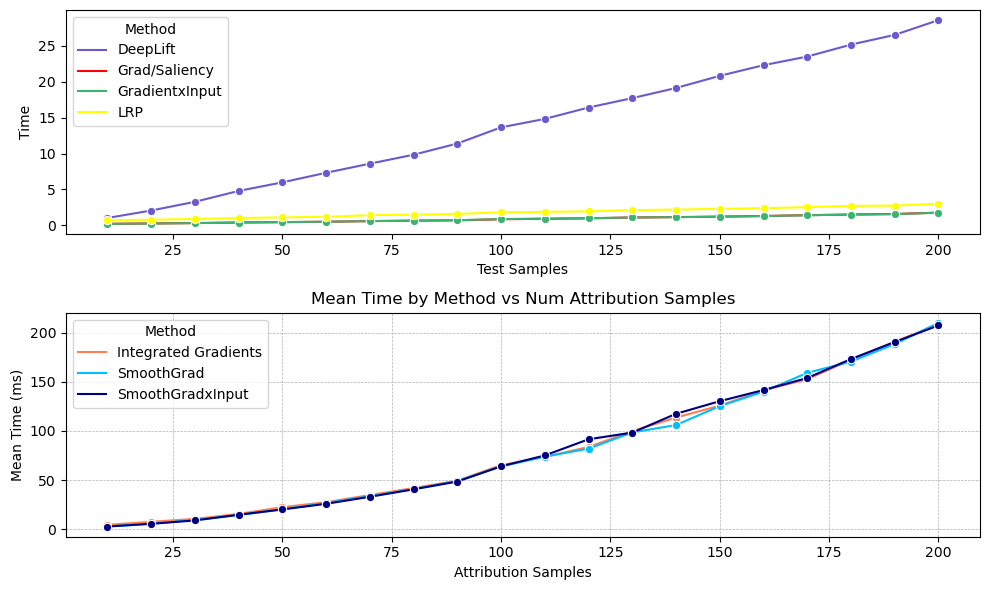

In [25]:
df1_mean = df1.groupby(['Test Samples', 'Method'])['Time'].mean().reset_index()
print(df1_mean)

df2_mean = df2.groupby(['Test Samples', 'Method'])['Time'].mean().reset_index()
print(df2_mean)


fig, ax = plt.subplots(2, figsize=(10, 6))
sns.lineplot(data=df1_mean, x='Test Samples', y='Time', hue='Method', marker='o', ax=ax[0], palette=method_colors)


plt.title('Mean Time by Method vs Num Attribution Samples')
plt.ylabel('Mean Time (ms)')
plt.xlabel('Attribution Samples')

sns.lineplot(data=df2_mean, x='Test Samples', y='Time', hue='Method', marker='o', ax=ax[1], palette=method_colors)


plt.xlabel('Attribution Samples')
plt.ylabel('Mean Time (ms)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Method')
plt.tight_layout()
plt.show()